# <center>Steam Game Data Analytics</center>
### <center>Web Mining Project</center>
- **Mission statement:**
    - Data acquisition
    - Analyze the game review data on Steam platform and try to make some explorative deployment.
        - Sentiment analytics
        - Product development advice
        - Player’s behavior analysis
        - Game recommendation
        - Game's prevailing trend prediction
- **Team Members:**
    - Fanyu WANG.    fwang15@stevens.edu
    - Fu YANG.       fyang24@stevens.edu
    - Kai ZHANG.     kzhang32@stevens.edu
    - Shuai WANG.    swang111@stevens.edu

## 1. Scrape Data from Steam Platform

- Scape HTML web pages using BeatifulSoup
    - References: 
        - https://www.dataquest.io/blog/web-scraping-tutorial-python/
        - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#
        
- Collect datasets (positive and negative reviews)
    * use Selenium and BeatifulSoup both
        - Web scraping with Python and Beautiful Soup is an excellent tool to have within your skillset. Use web scraping when the data you need to work with is available to the public, but not necessarily conveniently available.
        - When JavaScript provides or “hides” content, browser automation with Selenium will insure your code “sees” what you (as a user) should see. 
        - And finally, when you are scraping tables full of data, pandas is the Python data analysis library that will handle it all.
    * datasets involves **user_name, votes, how much products in an account, hours to play and so on**
    * store data into a single dataframe
    * store data into a signle csv file

In [1]:
# import requests package
import requests                   

# import BeautifulSoup from package bs4 (i.e. beautifulsoup4)
from bs4 import BeautifulSoup    

import re

### Ⅰ. BeatifulSoup
- sometimes Selenium webdriver is not stable

In [33]:
def web_scrape(address):
    # store user_name 
    nicks=[]
    # store recommendation information
    titles=[]
    # store hours the player played
    hours=[]
    # store review information
    comments=[]
    # store the number of people who thinks that this review is helpful
    helpfuls=[]
    # store the number of people who thinks that this review is funny
    funnys=[]
    # store the date the user commented
    dates=[]
    # store the number of games the user has
    products=[]
    # scrape 10 reviews per time
    # therefore we scraped 10000 reviews
    for i in range(1, 1001):
        # simulate the network requests
        url =  address + '/homecontent/?userreviewsoffset=' + str(10 * (i - 1)) + '&p=' + str(i) + '&workshopitemspage=' + str(i) + '&readytouseitemspage=' + str(i) + '&mtxitemspage=' + str(i) + '&itemspage=' + str(i) + '&screenshotspage=' + str(i) + '&videospage=' + str(i) + '&artpage=' + str(i) + '&allguidepage=' + str(i) + '&webguidepage=' + str(i) + '&integratedguidepage=' + str(i) + '&discussionspage=' + str(i) + '&numperpage=10&browsefilter=toprated&browsefilter=toprated&appid=435150&appHubSubSection=10&l=senglish&filterLanguage=default&searchText=&forceanon=1'
        html = requests.get(url).text.replace('<br>',' ')
        soup = BeautifulSoup(html, 'html.parser') 
        # scrape the information which we focus on
        reviews = soup.find_all('div', {'class': 'apphub_Card'})    
        for review in reviews:
            nick = review.find('div', {'class': 'apphub_CardContentAuthorName'})
            nicks.append(nick.text)
            title = review.find('div', {'class': 'title'}).text
            titles.append(title)
            hour = review.find('div', {'class': 'hours'}).text.split(' ')[0]
            hours.append(hour)
            product = review.find('div', {'class': 'apphub_CardContentMoreLink ellipsis'}).text.split()
            # this content may be null. when it is null, we think it equals to zero
            if len(product)==4:
                products.append(product[0])
            else:
                products.append('0')
            #link = nick.find('a').attrs['href']
            comment = review.find('div', {'class': 'apphub_CardTextContent'}).text
            temp=comment.split('\n')
            # there will be unwanted information. so we skip them.
            if len(temp)==3:
                comments.append(temp[2].strip('\t'))
            else:
                comments.append(temp[3].strip('\t'))
            # delete string "Posted: " since it is unused
            date = re.sub(r"Posted:"," ",comment.split('\n')[1].strip('\t')).strip()
            dates.append(date)
            helpful = review.find('div', {'class': 'found_helpful'}).text.split()[0]
            helpfuls.append(helpful)
            #helpful1 = review.find('div', {'class': 'found_helpful'}).text.split()[6]
            #funny = re.findall(r"\d+",review.find('div', {'class': 'found_helpful'}).text.split()[5])
            funny = review.find('div', {'class': 'found_helpful'}).text.split()
            # this content may be null. when it is null, we think it equals to zero
            if len(funny)==12:
                funnys.append(funny[6])
            else:
                funnys.append('0')
                
    # generate dataframe to store web information
    df = pd.DataFrame()
    df["names"] = nicks
    df["products#"] = products
    df["marked as helpful"] = helpfuls
    df["marked as funny"] = funnys
    df["post_date"] = dates
    df["Recommend?"] = titles
    df["times on record"] = hours
    df["review"] = comments
    
    # generate csv file
    # df.to_csv('game_data_negative.csv',index=False)
    return df

## 2. Data scrubbing

- Data scrubbing
    * for convinience, convert symbols to numbers. (eg. "No" to "0")
    * remove the words in stop_words list (which is posted in class)
    * remove the words (game and games) since the frequency is too high and they are negligible words
    * remove the unrecognized words (they may be Chinese or other language, emoji and so on)
    * remove the datasets with reviews which are empty after data scrubbing
    * remove the duplicate datesets since there is an iterative scraping issue (we define there will be 10 reviews every page, but in fact, the number is random based on the length of reviews).
    * date formatting. eg. "May 5, 2017" -> "2017/5/5", "May 5" -> "2018/5/5"

In [34]:
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
import numpy as np
import os
import time

### Ⅰ. POS (Part of Speech) Tagging
- The process of marking up a word in a text as corresponding to a particular part of speech (e.g. nouns, verbs, adjectives, adverbs etc.), based on both **its definition**, as well as its **context** — adjacent and related words in a phrase, sentence, or paragraph. 

In [35]:
def get_wordnet_pos(pos_tag):
    
    # if pos tag starts with 'J'
    if pos_tag.startswith('J'):
        # return wordnet tag "ADJ"
        return wordnet.ADJ

    # if pos tag starts with 'V'
    elif pos_tag.startswith('V'):
        # return wordnet tag "VERB"
        return wordnet.VERB

    # if pos tag starts with 'N'
    elif pos_tag.startswith('N'):
        # return wordnet tag "NOUN"
        return wordnet.NOUN

    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        # be default, return wordnet tag "NOUN"
        return wordnet.NOUN

### Ⅱ. Tokenization

- the process of breaking a stream of textual content up into words, terms, symbols, or some other meaningful elements called tokens.
    * Word (Unigram)
    * Bigram (Two consecutive words)
    * Trigram (Three consecutive words)
    * Sentence
- remove the pointless information
- data formatting and sorting

In [36]:
def tokenize(data):
    
    # Fomart the date       
    init_dates = []
    date_lst = data['post_date'].tolist()
    for i in range(len(data)):
        temp=date_lst[i].split(',')
        # when the review was posted in 2018, the system doesn't show "2018". We add it.
        if len(temp)==1:
            temp.append(' 2018')
        if len(temp)==2:
            date_temp=''.join(temp)
            conv=time.strptime(date_temp,"%B %d %Y")
            date_temp2=time.strftime("%Y/%m/%d",conv)
            init_dates.append(date_temp2)
    data["post_date"]=init_dates
    
    # Lemmatization: determining the lemma for a given word
    wordnet_lemmatizer = WordNetLemmatizer()
    
    # Regular expression pattern
    pattern = r'\w[\w\'-]*\w'
    
    init_reviews = []
    init_helpfuls = []
    stop_words = stopwords.words('english')
    stop_words.append("game")
    
    review = data["review"].values.tolist()
    helpfuls = data["marked as helpful"].values.tolist()
    
    for doc in review:
        doc = doc.lower()
        tokens = nltk.regexp_tokenize(doc, pattern)
        tagged_tokens= nltk.pos_tag(tokens)
        lemmatized_words=[wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag)) \
              for (word, tag) in tagged_tokens \
              if word not in stop_words and word not in string.punctuation]
        temp_str = ""
        for item in lemmatized_words:
            temp_str = temp_str + " " + item
        init_reviews.append(temp_str[1:])
    
    # convert "No" to "0"
    for line in helpfuls:
        if line=="No":
            init_helpfuls.append("0")
        else:
            init_helpfuls.append(line)
    
    
        
    # Generate csv file to save data without unuseful information.
    df = pd.DataFrame()
    df["user_name"] = data["names"].values.tolist()
    df["user_product"] = data["products#"].values.tolist()
    df["helpful"] = init_helpfuls
    df["funny"] = data["marked as funny"].values.tolist()
    df["post_date"] = data["post_date"].values.tolist()
    df["recommend_or_not"] = data["Recommend?"].values.tolist()
    df["game_time"] = data["times on record"].values.tolist()
    df["review"] = init_reviews
    # obtain the row index when contents of reviews are empty
    indx = df[df.review==''].index.tolist()
    # delete the corresponding datasets
    df1=df.drop(df.index[indx])
    # delete the duplicate datasets
    df1.drop_duplicates(subset ="user_name", 
                     keep = False, inplace = True)
    #sort df by date value
    df2=df1.sort_values(by='post_date')
    # csv
    df2.to_csv('C:/Users/yongk/Documents/PythonLearning/Steam Data Analysis/Data_main/tokened_normed_review_test.csv',index=False)
    # this method generate a dataframe with tokenized data sets
    return df2

### Ⅲ. Merge mupltiple csv files into a single one

In [37]:
def merge_csv():
    Folder_Path = r'C:\Users\yongk\Documents\PythonLearning\Steam Data Analysis\Data_main'          
    SaveFile_Path =  r'C:\Users\yongk\Documents\PythonLearning\Steam Data Analysis\Data_main'       
    SaveFile_Name = r'game_data_all.csv'              
 
    os.chdir(Folder_Path)
    # save file names into a list
    file_list = os.listdir()
 
    # read the first csv including headers
    df = pd.read_csv(Folder_Path +'\\'+ file_list[0])   #default utf-8
 
    # write the first csv to second one
    df.to_csv(SaveFile_Path+'\\'+ SaveFile_Name,encoding="utf_8_sig",index=False)
 
    # loop through all files
    for i in range(1,len(file_list)):
        df = pd.read_csv(Folder_Path + '\\'+ file_list[i])
        df.to_csv(SaveFile_Path+'\\'+ SaveFile_Name,encoding="utf_8_sig",index=False, header=False, mode='a+')

### Ⅳ. getdata function
- generate a datafram to store all data
- generate a csv file to store all data

In [38]:
def getdata():
    # obtain data including positive and negative reviews
    data_positive = web_scrape(address_positive)
    data_negative = web_scrape(address_negative)
    # concat two dataframes
    data = pd.concat([data_positive,data_negative],ignore_index=True)
    # generate csv files to store two dataframes
    data_positive.to_csv('C:/Users/yongk/Documents/PythonLearning/Steam Data Analysis/Data_main/game_data_positive.csv',index=False)
    data_negative.to_csv('C:/Users/yongk/Documents/PythonLearning/Steam Data Analysis/Data_main/game_data_negative.csv',index=False)
    # merge multiple csv
    merge_csv()# game_data_all.csv
    return data

## 3. Exploratory Data Analysis

- Exploratory Data Analysis
    - Sentiment Analysis
        - Ultilize a sample dataset(1982 high-quality reviews) we saved
        - Analyze data with Naive way based on positive words and negative words.
    - Find variable relations by scatter plot based on Naive Approach
        - Some initial conclusions
            + **Reviews with neutral attitude get more 'funny' from other players**
            + **Long reviews are not easy to get more 'funny'**
    - TF-IDF analysis
        - Generate TF-IDF Metrix
        - Find the index of most similar document

### Ⅰ. Sentiment analysis
- Analyze data with Naive way based on positive words and negative words.

In [42]:
import pandas as pd

def naive_approach(token_path,posi_word_path,nega_word_path):
    '''
    This function take a csv file with tokenized review column as input
    and return a dataframe with additional columns 'positive freq' and 'negative freq'
    Args:
        token_path: file path of 'tokened_normed_review_v2.csv'
        posi_word_path: file path of 'positive-words.txt'
        nega_word_path: file path of 'negative-words.txt'
    Return:
        data: dataframe created from the csv file with two new columns 'positive freq' and 'negative freq'
    '''

    data = pd.read_csv(token_path,header = 0)
    with open(posi_word_path, 'r') as f1:
        positive_words = [line.strip() for line in f1]
    with open(nega_word_path, 'r') as f2:
        negative_words = [line.strip() for line in f2]
        
    reviews = list(data['review'])
    positive_tokens = []
    negative_tokens = []
    for doc in reviews:
        doc_positive_tokens = [token for token in doc.split()
                           if token in positive_words]
        positive_tokens.append(len(doc_positive_tokens)/len(doc))

        doc_negative_tokens = [token for token in doc.split()
                          if token in negative_words]
        negative_tokens.append(len(doc_negative_tokens)/len(doc))
        
    data['positive freq'] = positive_tokens
    data['negative freq'] = negative_tokens
    data['attitude']=data['positive freq']-data['negative freq']
    return data

## II. Try to find variable relations by scatter plot
- Reviews with neutral attitude get more 'funny' from other players
- Long reviews are not easy to get more 'funny' 

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

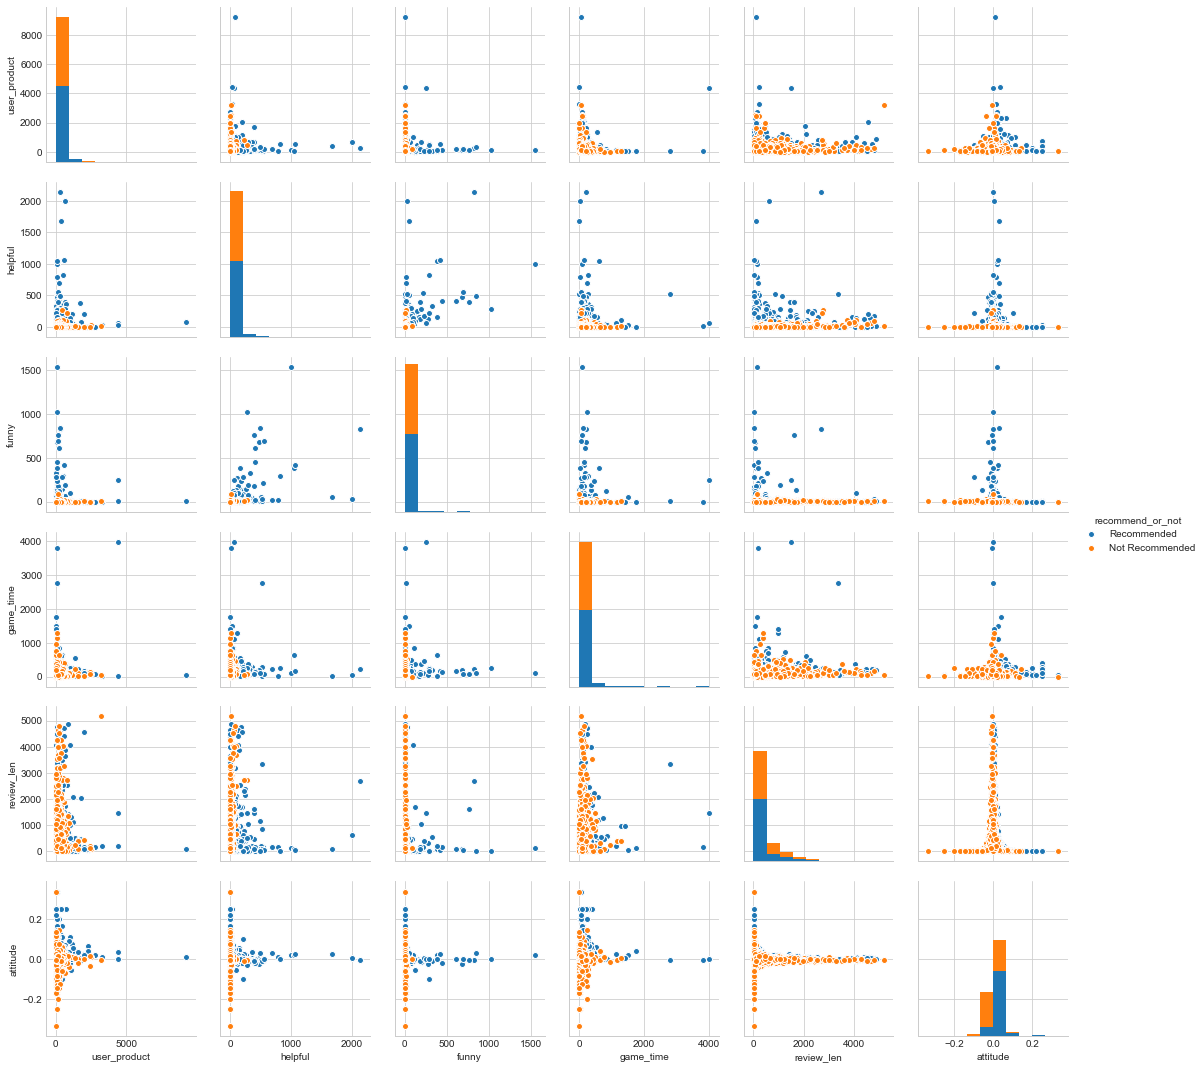

In [45]:
token_path = r'C:/Users/yongk/Documents/PythonLearning/Steam Data Analysis/tokened_normed_review_v2.csv'
posi_word_path = r'C:/Users/yongk/Documents/PythonLearning/Steam Data Analysis/positive-words.txt'
nega_word_path = r'C:/Users/yongk/Documents/PythonLearning/Steam Data Analysis/negative-words.txt'
data = naive_approach(token_path,posi_word_path,nega_word_path)
data.user_product=data.user_product.apply(lambda x :x.replace(',','')).astype(int)
data.helpful=data.helpful.apply(lambda x :x.replace(',','')).astype(int)
data.funny=data.funny.apply(lambda x :x.replace(',','')).astype(int)
data.game_time=data.game_time.apply(lambda x :x.replace(',','')).astype(float)
data['review_len']=data.review.apply(lambda x: len(x))
data.head()
%matplotlib inline
sns.set_style("whitegrid");
sns.pairplot(data=data, 
             x_vars=['user_product','helpful','funny','game_time','review_len','attitude'], 
             y_vars=['user_product','helpful','funny','game_time','review_len','attitude'], 
             hue='recommend_or_not')

### Ⅲ. Term Frequency and Inverse Dcoument Frequency (TF-IDF) Analysis

In [39]:
# This function is to tokenalize normal review before we do TF-IDF #
def get_doc_tokens(doc):
    stop_words = stopwords.words('english')
    stop_words.append("game")
    tokens=[token.strip() \
            for token in nltk.word_tokenize(doc) if token.strip() not in stop_words and\
               token.strip() not in string.punctuation]
    # create token count dictionary
    token_count={token:tokens.count(token) for token in set(tokens)}
    return token_count


# This function is to get TF-IDF matrix #
def get_tf_idf(reviews):
    
    docs_tokens={idx:get_doc_tokens(doc) for idx,doc in enumerate(reviews)}

    # since we have a small corpus, we can use dataframe to get document-term matrix
    dtm=pd.DataFrame.from_dict(docs_tokens, orient="index" )
    dtm=dtm.fillna(0)
    # convert dtm to numpy arrays
    tf=dtm.values

    # sum the value of each row
    doc_len=tf.sum(axis=1)

    # divide dtm matrix by the doc length matrix
    tf=np.divide(tf, doc_len[:,None])

    # get document freqent
    df=np.where(tf>0,1,0)

    # get idf
    smoothed_idf=np.log(np.divide(len(reviews)+1, np.sum(df, axis=0)+1))+1

    # get tf-idf
    smoothed_tf_idf=tf*smoothed_idf
    
    return smoothed_tf_idf

In [40]:
from scipy.spatial import distance

# This function is to get the most similarity review given a review_id #
def find_similar_doc(doc_id, smoothed_tf_idf):
    similarity=1-distance.squareform(distance.pdist(smoothed_tf_idf, 'cosine'))
    
    # find top doc similar to first one
    best_matching_doc_id = np.argsort(similarity)[:,::-1][doc_id,0:2][1]
    similarity = similarity[doc_id,best_matching_doc_id]  
    return best_matching_doc_id, similarity

## 5. Trend Prediction
- <span style="color:blue"> **Polynomial Curve Fitting** </span>
    - Least squares polynomial fit.

    - Fit a polynomial p(x) = p[0] * x**deg + ... + p[deg] of degree deg to points (x, y). Returns a vector of coefficients p that minimises the squared error.
    
- <span style="color:blue"> **Exponential Curve Fitting** </span>
    - The curve fitter calculates the best fitting exponential function given a set of points.
    - This function is $f(x)=ab^x$
    - scipy.optimize.curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

    - Use non-linear least squares to fit a function, f, to data.

    - Assumes ydata = f(xdata, *params) + eps
- <span style="color:blue"> **Time-Series Forecasting** </span>
    - Forecasting involves taking models fit on historical data and using them to predict future observations.
    - using python API **fbprophet**.   Reference: https://facebook.github.io/prophet/docs/quick_start.html

### Ⅰ. General Trend Discovery

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import *
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp 
from fbprophet import Prophet
import time

In [3]:
def general_trend (datapath):
    print("General Trend:")
    # read original data
    df_temp=pd.read_csv(datapath)
    #delete the last row since the only one data on Nov makes confusion
    df=df_temp.drop(df_temp.index[len(df_temp)-1])
    num_total=len(df)
    
    # date form transmission (e.g. 2016/09/15 ---> 2016-09-15)
    for i in range(num_total):
        w=df["post_date"][i].split('/')
        q='-'.join(w)
        df.loc[i,"post_date"]= q
    
    # for the puepose on extracting data based on y/m
    ym=['2016-09','2016-10','2016-11','2016-12','2017-01','2017-02','2017-03','2017-04','2017-05','2017-06','2017-07','2017-08','2017-09',\
   '2017-10','2017-11','2017-12','2018-01','2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08',\
   '2018-09','2018-10']
    df['ym']=0
    for i in range(num_total):
        df.loc[i,"ym"]= df["post_date"][i][0:7]
    
    df_time=[]
    df_time_pos=[]
    df_time_neg=[]
    num_reviews=[]
    num_reviews_pos=[]
    num_reviews_neg=[]
    for a in ym:
        # store the dataframe every month into a list. df_time[0] means the dataframe on 15/09/2016
        df_time.append(df[df["ym"]==a])
        df_time_pos.append(df[(df["ym"]==a) & (df["recommend_or_not"]=="Recommended")])
        df_time_neg.append(df[(df["ym"]==a) & (df["recommend_or_not"]=="Not Recommended")])
    time_interval=len(df_time)
    for i in range(time_interval):
        num_reviews.append(len(df_time[i]))
        num_reviews_pos.append(len(df_time_pos[i]))
        num_reviews_neg.append(len(df_time_neg[i]))
        
    # positive / total
    num_pro=[]
    for i in range(len(num_reviews)):
        if num_reviews[i]==0:
            num_pro.append(0)
        else:
            num_pro.append(num_reviews_pos[i]/num_reviews[i]*100)
            
    # plot
    plt.subplot(211) 
    s1=plt.bar(ym, num_reviews, label='Negative')
    s2=plt.bar(ym, num_reviews_pos, label='Positive')
    plt.title("Review Analysis per Month")
    plt.ylabel('number of reviews')
    plt.xlabel('data')
    plt.legend()
    time.sleep(3)

    plt.subplot(212) 
    s3=plt.bar(ym, num_pro, label='positive feedback')
    plt.title("postive rating")
    plt.ylabel('posivie/total %')
    plt.xlabel('data')
    plt.legend()
    time.sleep(5)

    print("Average of positive rating: \n")
    ave_num = sum(num_pro)/len(num_pro)
    print(ave_num)

### Ⅱ. **Polynomial Curve Fitting** and Exponential Curve Fitting

In [4]:
def trend_prediction_sketch(datapath):
    print("Polynomial Curve Fitting")
    # read original data
    df_temp=pd.read_csv(datapath)
    #delete the last row since the only one data on Nov makes confusion
    df=df_temp.drop(df_temp.index[len(df_temp)-1])
    num_total=len(df)
    
    # date form transmission (e.g. 2016/09/15 ---> 2016-09-15)
    for i in range(num_total):
        w=df["post_date"][i].split('/')
        q='-'.join(w)
        df.loc[i,"post_date"]= q
    
    # Data analysis per day (2016-09-15 ~ 2018-8-31)
    # create a dictionary to store number of reviews every day
    dic ={}
    for i in range(num_total):
        date = df.iloc[i]["post_date"]
        if date not in dic:
            dic[date] =1
        else:
            dic[date]+=1
            
    # construct data collection based on fbprophet's requirment
    ds=[]
    y=[]
    for name in dic.keys():
        ds.append(name)
    for num in dic.values():
        y.append(num)
        
    df_daily_all = pd.DataFrame() 
    df_daily_all["ds"] = ds
    df_daily_all["y"] = y
    df_daily = df_daily_all.drop(df_daily_all.index[620:]) # known
    df_daily_actual = df_daily_all.drop(df_daily_all.index[:620]) # need prediction
    df_daily_official = df_daily_all.iloc[284:620] # after release date, before Oct 2018
    df_daily_official_all = df_daily_all.iloc[284:] # after release date
    
    # third degree polynomial
    y_temp=[]
    x = np.arange(0,len(df_daily_official),1)
    for i in range(len(df_daily_official)):
        y_temp.append(df_daily_official["y"][i+284])
    y = np.array(y_temp)
    z1 = np.polyfit(x, y, 3)
    p1 = np.poly1d(z1)
    print(p1) # print polynomial formula
    yvals = p1(x)  # fit y

    plot1 = plt.plot(x, y, 's',label='original values')
    plot2 = plt.plot(x, yvals, 'r',label='polyfit values')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc=1) 
    plt.title('third dgree polyfitting')
    plt.show()
    time.sleep(3)
    
    dist_poly = []
    x_poly = np.arange(0,len(df_daily_official_all),1)
    y_poly = [(-1.054e-05 *x*x*x - 0.006519 *x*x + 1.23 *x +73.64) for x in x_poly] 
    for i in range(len(df_daily_official_all)):
        temp=abs(y_poly[i]-df_daily_all["y"][i])
        dist_poly.append(temp)
    score_poly = sum(dist_poly)/len(df_daily_all)
    print("similarity score is :")
    print(score_poly)
    print("\n")
    
    # exponential curve fitting
    print("Exponential Curve Fitting:")
    x = np.arange(1,len(df_daily_official)+1,1)
    y = np.array(y_temp)
    def func(x,a,b):
        return a*np.exp(b/x)
    popt, pcov = curve_fit(func, x, y)
    a=popt[0]
    b=popt[1]
    yvals=func(x,a,b)
    print (u'parameter a:', a)
    print (u'parameter b:', b)
    plot1=plt.plot(x, y, '*',label='original values')
    plot2=plt.plot(x, yvals, 'r',label='curve_fit values')
    plt.xlabel('x axis')
    plt.ylabel('y axis')
    plt.legend(loc=1)
    plt.title('curve_fit')
    time.sleep(3)
    
    dist_exp = []
    x_exp = np.arange(1,len(df_daily_official_all)+1,1)
    y_exp = [12.30452657404054*np.exp(2.869100023130686/x) for x in x_exp] 
    for i in range(len(df_daily_official_all)):
        temp=abs(y_exp[i]-df_daily_all["y"][i])
        dist_exp.append(temp)
    score_exp = sum(dist_exp)/len(df_daily_all)
    print("similarity score is :")
    print(score_exp)

### fbprophet Time-Series Forecasting
- The input to Prophet is always a dataframe with two columns: **ds** and **y**. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.
- The predict method will assign each row in future a predicted value which it names yhat. If you pass in historical dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [14]:
def trend_prediction_tsf(datapath):
    print("Time-Series Forecasting:")
    # read original data
    df_temp=pd.read_csv(datapath)
    #delete the last row since the only one data on Nov makes confusion
    df=df_temp.drop(df_temp.index[len(df_temp)-1])
    num_total=len(df)
    
    # date form transmission (e.g. 2016/09/15 ---> 2016-09-15)
    for i in range(num_total):
        w=df["post_date"][i].split('/')
        q='-'.join(w)
        df.loc[i,"post_date"]= q
    
    # Data analysis per day (2016-09-15 ~ 2018-8-31)
    # create a dictionary to store number of reviews every day
    dic ={}
    for i in range(num_total):
        date = df.iloc[i]["post_date"]
        if date not in dic:
            dic[date] =1
        else:
            dic[date]+=1
            
    # construct data collection based on fbprophet's requirment
    ds=[]
    y=[]
    for name in dic.keys():
        ds.append(name)
    for num in dic.values():
        y.append(num)
        
    df_daily_all = pd.DataFrame() 
    df_daily_all["ds"] = ds
    df_daily_all["y"] = y
    df_daily = df_daily_all.drop(df_daily_all.index[620:]) # known
    df_daily_actual = df_daily_all.drop(df_daily_all.index[:620]) # need prediction
    df_daily_official = df_daily_all.iloc[284:620] # after release date, before Oct 2018
    df_daily_official_all = df_daily_all.iloc[284:] # after release date
    
    # model fitting and prediction
#     model = Prophet()
#     model.fit(df_daily)
#     future = model.make_future_dataframe(periods=61, freq = 'd')
#     print("The time-series forecasting with all sample data: \n")
#     forecast = model.predict(future)
#     model.plot(forecast);
#     time.sleep(3)
    
    # model fitting and prediction (selected sample)
    model2 = Prophet()
    model2.fit(df_daily_official)
    future2 = model2.make_future_dataframe(periods=61, freq = 'd')
    forecast2 = model2.predict(future2)
    forecast2.head()
    print("The time-series forecasting with selected sample data (for better fitting ratio): \n")
    #model2.plot(forecast2);
    time.sleep(5)
    
    # combine actual values with predicted values
    df_daily_official_all.set_index('ds', inplace=True)
    forecast2.set_index('ds', inplace=True)
    viz_df2 = df_daily_official_all.join(forecast2[['yhat', 'yhat_lower','yhat_upper']], how = 'outer').fillna(0)
    
    # calculate the similar score(Time-Series Forecasting)
    def dist(dataframe):
        dist=[]
        length=len(dataframe)
        for i in range(length):
            temp=abs((abs(dataframe['yhat'][i])-abs(dataframe['y'][i])))
            dist.append(temp)
        return dist

    distance = dist(viz_df2)
    score = sum(distance)/len(viz_df2)
    
    #print("Visualization : ")
    viz_df2[['y', 'yhat']].plot()
    time.sleep(3)
    
    print("similarity score is : \n")
    print(score)

## 6. Feature Extraction

In [18]:
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from nltk.cluster import KMeansClusterer, cosine_distance
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from numpy.random import shuffle
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import math

K:\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
K:\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


### Ⅰ. Single-Word Features Analysis
- Topic Modeling using LDA method
- Common techniques to estimate these probabilities are EM (Expectation-Maximization), Collapsed Gibbs Sampling (See Blei's paper for details)
  - Collapsed Gibbs Sampling: https://www.youtube.com/watch?v=u7l5hhmdc0M
    1. Randomly assign each word in each sample to a topic 
    2. Iteratively update the assignment of each word

In [19]:
def topic(file_path):
    raw_df = pd.read_csv(file_path)

    #raw_df.user_product=raw_df.user_product.apply(lambda x :x.replace(',','')).astype(int)
    #raw_df.helpful=raw_df.helpful.apply(lambda x :x.replace(',','')).astype(int)
    #raw_df.funny=raw_df.funny.apply(lambda x :x.replace(',','')).astype(int)
    #raw_df.game_time=raw_df.game_time.apply(lambda x :x.replace(',','')).astype(float)
    raw_df['review_len']=raw_df.review.apply(lambda x: len(x))

    #filter_condition = (raw_df.game_time > 60) & (raw_df.helpful > 0) & (raw_df.review_len > 10)
    #filtered_df = raw_df[filter_condition]
    filtered_df = raw_df
    filtered_df.shape

    # get bigrams
    text = []
    tagged_tokens = []
    for doc in filtered_df['review']:
        tokens=nltk.word_tokenize(doc)
        temp_tokens= nltk.pos_tag(tokens)
        for x in temp_tokens:
            tagged_tokens.append(x)

    bigrams=list(nltk.bigrams(tagged_tokens))
    for (x,y) in bigrams:
        if x[1].startswith('J') and y[1].startswith('N'):
            text.append(x[0] + " " + y[0])
            
            
    #text = list(filtered_df['review'])
    print(text[0])
    print(tagged_tokens[0])
    
    stop_words = stopwords.words('english')
    
    other_words = ["game",'divinity','original',"sin",'play','use','make','really','thing','get','go','would','early','access']
    stop_words += other_words
    
    # create tf-idf
    tf_vectorizer = CountVectorizer(max_df = 0.90, min_df = 5, stop_words = stop_words)
    tf = tf_vectorizer.fit_transform(text)
    tf_feature_names = tf_vectorizer.get_feature_names()
    print(tf_feature_names[0:10])
    print(tf.shape)

    from sklearn.model_selection import train_test_split
    tf_train, tf_test = train_test_split(tf, test_size=0.3, random_state=0)
    
    
    num_topics = 10

    # Run LDA. For details, check
    # http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation.perplexity

    # max_iter control the number of iterations 
    # evaluate_every determines how often the perplexity is calculated
    # n_jobs is the number of parallel threads
    lda = LatentDirichletAllocation(n_components=num_topics, \
                                max_iter=30,verbose=1,
                                evaluate_every=1, n_jobs=1,
                                random_state=0).fit(tf_train)
    
    
    # lda for test set
    topic_assign_test = lda.transform(tf_test)

    # find the topic with top one highest possibility
    top_one_topic = [doc.argsort()[-1] for doc in topic_assign_test]

    top_one_topic
    
    
    num_top_words=20

    # lda.components_ returns a KxN matrix
    # for word distribution in each topic.
    # Each row consists of 
    # probability (counts) of each word in the feature space

    for topic_idx, topic in enumerate(lda.components_):
        #print ("Topic %d:" % (topic_idx))
        # print out top 20 words per topic 
        words=[(tf_feature_names[i],topic[i]) \
               for i in topic.argsort()[::-1][0:num_top_words]]
        #print(words)
        #print("\n")
        
    
    

    num_top_words=50
    f, axarr = plt.subplots(5, 2, figsize=(20, 20));

    for topic_idx, topic in enumerate(lda.components_):
        # create a dataframe with two columns (word, weight) for each topic

        # create a word:count dictionary
        f={tf_feature_names[i]:topic[i] for i in topic.argsort()[::-1][0:num_top_words]}

        # generate wordcloud in subplots
        wordcloud = WordCloud(width=480, height=450, margin=0, background_color="black");
        _ = wordcloud.generate_from_frequencies(frequencies=f);

        _ = axarr[math.floor(topic_idx/2), topic_idx%2].imshow(wordcloud, interpolation="bilinear");
        _ = axarr[math.floor(topic_idx/2), topic_idx%2].set_title("Topic: "+str(topic_idx));
        _ = axarr[math.floor(topic_idx/2), topic_idx%2].axis('off')

    plt.tight_layout()
    plt.show()

### Ⅱ. Bigram Features Analysis
- Phrases: Bigrams (2 consecutive words)
- How to get bigrams:
    1. First tokenize text into unigrams
    2. Slice through the list of unigrams to get bigrams

In [21]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import nltk
import pandas as pd
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [22]:
def lda():
    #read data
    df = pd.read_csv("BIA-660 Project Data Subset.csv")
    #choose reviews that at least one player think it is helpful
    docs = df[(df.recommend_or_not == "Not Recommended") & (df.helpful != "0")].review
    text = []
    tagged_tokens = []
    #tokenize each review and give each token a Part of Speech tag
    for doc in docs:
        tokens=nltk.word_tokenize(doc)
        temp_tokens= nltk.pos_tag(tokens)
        for x in temp_tokens:
            tagged_tokens.append(x)
    #use tagged tokens to get bigrams
    bigrams=list(nltk.bigrams(tagged_tokens))
    for (x,y) in bigrams:
        if x[1].startswith('J') and y[1].startswith('N'):
            text.append(x[0] + " " + y[0])
    stop_words = stopwords.words('english')
    
    tf_vectorizer = CountVectorizer(max_df=0.90, min_df=50, stop_words = stop_words)
    tf = tf_vectorizer.fit_transform(text)
    tf_feature_names = text
    #split dataset into train (80%) and test sets (20%)
    X_train, X_test = train_test_split(tf, test_size=0.2, random_state=0)
    #set topic number to 4
    num_topics = 4
    lda = LatentDirichletAllocation(n_components=num_topics, \
                                learning_method='online', \
                                max_iter=10,verbose=0, n_jobs=1,
                                random_state=0).fit(X_train)
    #choose top 20 words per topic
    num_top_words = 20
    #print out results
    for topic_idx, topic in enumerate(lda.components_):
        print ("Topic %d:" % (topic_idx))
        words=[(tf_feature_names[i],topic[i]) for i in topic.argsort()[::-1][0:num_top_words]]
        print(words)
        print("\n")

## 7. Classification
- Input: raw reviews
- Output: Recommended or Not Recommended
- Models:
    1. Naive Bayes Model
    2. SVM Model
    3. Decision Tree Model
    4. Neural Network Model
    5. KNN Model
    6. Advanced NB Model

In [24]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import spacy
import scipy 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

K:\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
K:\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [25]:
def readfiles(path1,path2,path3):
    data = pd.read_csv(path1,header=0)
    with open(path2,'r') as f:       
        positive_words=[line.strip() for line in f]
    with open(path3,'r') as f: 
        negative_words=[line.strip() for line in f]
    return data,positive_words,negative_words


# lemmatize words and get word sentiment
def sent_words(text, nlp, positive_words, negative_words):   
    doc = nlp(text.lower())
    tokens=[]
    positive = []
    negative =[]
    tags =[]    
    for token in doc:            
        if not (token.is_punct or token.is_space ):            
            if token.lemma_ in positive_words:
                positive.append(token.lemma_)               
            if token.lemma_ in negative_words:
                negative.append(token.lemma_)            
            if (token.lemma_!='-PRON-'):
                tokens.append(token.lemma_)
            else:
                tokens.append(token.text)                
            tags.append(token.pos_)           
    return {"cleaned_text":" ".join(tokens), \
            "pos":len(positive),\
            "neg":len(negative)}


def Naive_Bayes_Model(dtm,metrics):
    # Run 5-fold cross validation to show the generalizability of the NB model
    clf = MultinomialNB()
    cv = cross_validate(clf, dtm, data["recommend_or_not"], \
                scoring=metrics, cv=5,)
    print("\nAverage testing performance of Naive Bayes benchmarking model:")
    print('precision_macro:', np.mean(np.array(cv['test_precision_macro'])))
    print('recall_macro:', np.mean(np.array(cv['test_recall_macro'])))
    print('f1_macro:', np.mean(np.array(cv['test_f1_macro'])))
    print('accuracy:', np.mean(np.array(cv['test_accuracy'])))

    
def SVM_Model(dtm,metrics):
    # Run 5-fold cross validation to show the generalizability of the SVM model
    clf = svm.LinearSVC()
    cv = cross_validate(clf, dtm, data["recommend_or_not"], \
                        scoring=metrics, cv=5)
    print("\nAverage testing performance of SVM benchmarking model:")
    print('precision_macro:', np.mean(np.array(cv['test_precision_macro'])))
    print('recall_macro:', np.mean(np.array(cv['test_recall_macro'])))
    print('f1_macro:', np.mean(np.array(cv['test_f1_macro'])))
    print('accuracy:', np.mean(np.array(cv['test_accuracy'])))


def DecisionTree_Model(dtm,metrics):
    # Run 5-fold cross validation to show the generalizability of the Decision Tree model
    clf = tree.DecisionTreeClassifier()
    cv = cross_validate(clf, dtm, data["recommend_or_not"], \
                        scoring=metrics, cv=5)
    print("\nAverage testing performance of Decision Tree benchmarking model:")
    print('precision_macro:', np.mean(np.array(cv['test_precision_macro'])))
    print('recall_macro:', np.mean(np.array(cv['test_recall_macro'])))
    print('f1_macro:', np.mean(np.array(cv['test_f1_macro'])))
    print('accuracy:', np.mean(np.array(cv['test_accuracy'])))

    
def KNN_Model(dtm,metrics):
    # Run 5-fold cross validation to show the generalizability of the KNN model
    clf = KNeighborsClassifier(n_neighbors=20)
    cv = cross_validate(clf, dtm, data["recommend_or_not"], \
                        scoring=metrics, cv=5)
    print("\nAverage testing performance of KNN benchmarking model:")
    print('precision_macro:', np.mean(np.array(cv['test_precision_macro'])))
    print('recall_macro:', np.mean(np.array(cv['test_recall_macro'])))
    print('f1_macro:', np.mean(np.array(cv['test_f1_macro'])))
    print('accuracy:', np.mean(np.array(cv['test_accuracy'])))
    

def neural_network_Model(dtm,metrics):
    # Run 5-fold cross validation to show the generalizability of the CNN model
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                   hidden_layer_sizes=(5, 2), random_state=1)
    cv = cross_validate(clf, dtm, data["recommend_or_not"], \
                        scoring=metrics, cv=5)
    print("\nAverage testing performance of Neural Network benchmarking model:")
    print('precision_macro:', np.mean(np.array(cv['test_precision_macro'])))
    print('recall_macro:', np.mean(np.array(cv['test_recall_macro'])))
    print('f1_macro:', np.mean(np.array(cv['test_f1_macro'])))
    print('accuracy:', np.mean(np.array(cv['test_accuracy'])))

    
def advanced_NB(dtm,metrics,data_new):
    # parameter tuning 
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB())])
    parameters = {'tfidf__min_df':[10,15,18],
                  'tfidf__stop_words':["english"],
                  'clf__alpha': [0.5,1.0,1.5],}
    metric =  "f1_macro"
    gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)
    gs_clf = gs_clf.fit(data["review"], data["recommend_or_not"])
    print("\nBest parameters for Naive Bayes:")
    for param_name in gs_clf.best_params_:
        print(param_name,": ",gs_clf.best_params_[param_name])
    print("best f1_macro:", gs_clf.best_score_)
    
    # Run 5-fold cross validation to show the generalizability of the modified NB model
    tfidf_vect = TfidfVectorizer(stop_words='english',min_df=gs_clf.best_params_['tfidf__min_df']) 
    dtm2= tfidf_vect.fit_transform(data_new["cleaned_text"])
    dtm3=scipy.sparse.hstack([dtm2,data_new[["neg","pos"]].values])

    # parameter tuning + lemmatized text + word sentiment
    clf = MultinomialNB(alpha=gs_clf.best_params_['clf__alpha'])
    cv = cross_validate(clf, dtm3, data["recommend_or_not"], \
                    scoring=metrics, cv=5,)

    print("\nAverage performance of modified NB model:")
    print('Precision_macro:', np.mean(np.array(cv['test_precision_macro'])))
    print('Recall_macro:', np.mean(np.array(cv['test_recall_macro'])))
    print('F1_macro:', np.mean(np.array(cv['test_f1_macro'])))
    print('Accuracy:', np.mean(np.array(cv['test_accuracy'])))
    
    
def advanced_SVM(dtm,metrics,data_new):
    # parameter tuning 
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', svm.LinearSVC())])
    parameters = {'tfidf__min_df':[1,2,5],
                  'tfidf__stop_words':["english"],
                  'clf__C': [1.0,1.5,2.0],}
    metric =  "f1_macro"
    gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)
    gs_clf = gs_clf.fit(data["review"], data["recommend_or_not"])
    print("\nBest parameters for SVM:")
    for param_name in gs_clf.best_params_:
        print(param_name,": ",gs_clf.best_params_[param_name])
    print("best f1_macro:", gs_clf.best_score_)
    
    # Run 5-fold cross validation to show the generalizability of the modified SVM model
    tfidf_vect = TfidfVectorizer(stop_words='english',min_df=gs_clf.best_params_['tfidf__min_df']) 
    dtm2= tfidf_vect.fit_transform(data_new["cleaned_text"])
    dtm3=scipy.sparse.hstack([dtm2,data_new[["neg","pos"]].values])

    # parameter tuning + lemmatized text + word sentiment
    clf = svm.LinearSVC(C=gs_clf.best_params_['clf__C'])
    cv = cross_validate(clf, dtm3, data["recommend_or_not"], \
                    scoring=metrics, cv=5,)

    print("\nAverage performance of modified SVM model:")
    print('Precision_macro:', np.mean(np.array(cv['test_precision_macro'])))
    print('Recall_macro:', np.mean(np.array(cv['test_recall_macro'])))
    print('F1_macro:', np.mean(np.array(cv['test_f1_macro'])))
    print('Accuracy:', np.mean(np.array(cv['test_accuracy'])))
    
    
def run5models(data,positive_words,negative_words):
    tfidf_vect = TfidfVectorizer(stop_words='english') 
    dtm= tfidf_vect.fit_transform(data["review"])
    metrics =  ["precision_macro", "recall_macro","f1_macro","accuracy"] 
    Naive_Bayes_Model(dtm,metrics)
    SVM_Model(dtm,metrics)
    DecisionTree_Model(dtm,metrics)
    KNN_Model(dtm,metrics)
    neural_network_Model(dtm,metrics)
    
    nlp = spacy.load('en_core_web_sm')
    # lemmatize words and get pos/neg words
    data_new = data.review.apply(lambda s: \
        pd.Series(sent_words(s, nlp, positive_words, negative_words)))
    advanced_NB(dtm,metrics,data_new)
    advanced_SVM(dtm,metrics,data_new)

## 8. Test

In [41]:
if __name__ == "__main__":
    
# Test "Scrape Data from Steam Platform"
    # Data from "Divinity: Original Sin 2"
    address_positive = 'https://steamcommunity.com/app/435150/positivereviews'
    # https://steamcommunity.com/app/435150/
    address_negative = 'http://steamcommunity.com/app/435150/negativereviews'
    data = getdata() # get raw datasets
    
    # output
    # there are some problems about the output (posive, negative)
    #print("Quantities of positive reviews")
    #print(len(web_scrape(address_positive)))
    #print("Quantities of negative reviews")
    #print(len(web_scrape(address_negative)))
    print("Quantities of all reviews")
    print(len(data))
    print("\n")
    
# Test "Data Tokenization and normalization"
    tokenized_data = tokenize(data)
    # output
    print("Quantities of reviews after tokenization (remove unuseful infomation)")
    print(len(tokenized_data))
    print('\n')
# Test "Data Analysis"
    # Sentiment Analysis
    
    # TF-IDF Analysis
    reviews = tokenized_data["review"].values.tolist()
    tf_idf = get_tf_idf(reviews)
    print("Smoothed TF-IDF Matrix")
    print(tf_idf)
    
    print(find_similar_doc(1,tf_idf))

Quantities of all reviews
11152


Quantities of reviews after tokenization (remove unuseful infomation)
5442


Smoothed TF-IDF Matrix
[[0.42060811 0.17481931 0.25093148 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.18826695 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.01501516 0.         ... 0.05465606 0.05465606 0.05465606]]
(458, 0.34201694807505667)


## Trend Prediction
- similary_score = abs(actual_values-predicted values)/sample_size

General Trend:
Average of positive rating: 

81.69031102811851


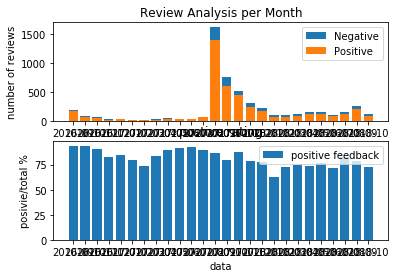

In [6]:
datapath="BIA-660 Project Data Subset.csv"
general_trend(datapath)

Polynomial Curve Fitting
            3            2
-1.054e-05 x + 0.006519 x - 1.23 x + 73.64


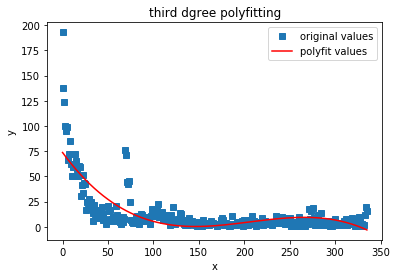

similarity score is :
163.62900364951395


Exponential Curve Fitting:
parameter a: 12.30452657404054
parameter b: 2.869100023130686
similarity score is :
7.792709825757792


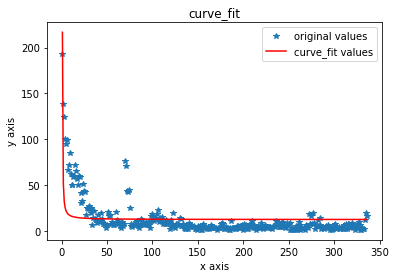

In [7]:
trend_prediction_sketch(datapath)

Time-Series Forecasting:


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time-series forecasting with selected sample data (for better fitting ratio): 

similarity score is : 

4.87978148756082


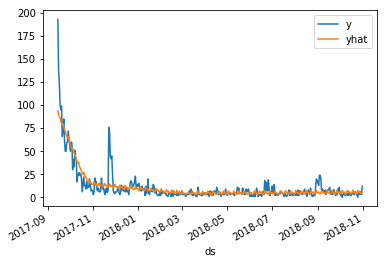

In [15]:
trend_prediction_tsf(datapath)

## Feature Extraction

alpha release
('amaze', 'NN')
['able', 'action', 'alpha', 'amount', 'armor', 'aspect', 'awesome', 'bad', 'best', 'big']
(1041, 88)


K:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


iteration: 1 of max_iter: 30, perplexity: 466.9930
iteration: 2 of max_iter: 30, perplexity: 246.3487
iteration: 3 of max_iter: 30, perplexity: 187.1891
iteration: 4 of max_iter: 30, perplexity: 166.2257
iteration: 5 of max_iter: 30, perplexity: 157.4325
iteration: 6 of max_iter: 30, perplexity: 153.5336
iteration: 7 of max_iter: 30, perplexity: 151.6791
iteration: 8 of max_iter: 30, perplexity: 150.7317
iteration: 9 of max_iter: 30, perplexity: 150.2152
iteration: 10 of max_iter: 30, perplexity: 149.9170
iteration: 11 of max_iter: 30, perplexity: 149.7363
iteration: 12 of max_iter: 30, perplexity: 149.6221
iteration: 13 of max_iter: 30, perplexity: 149.5475


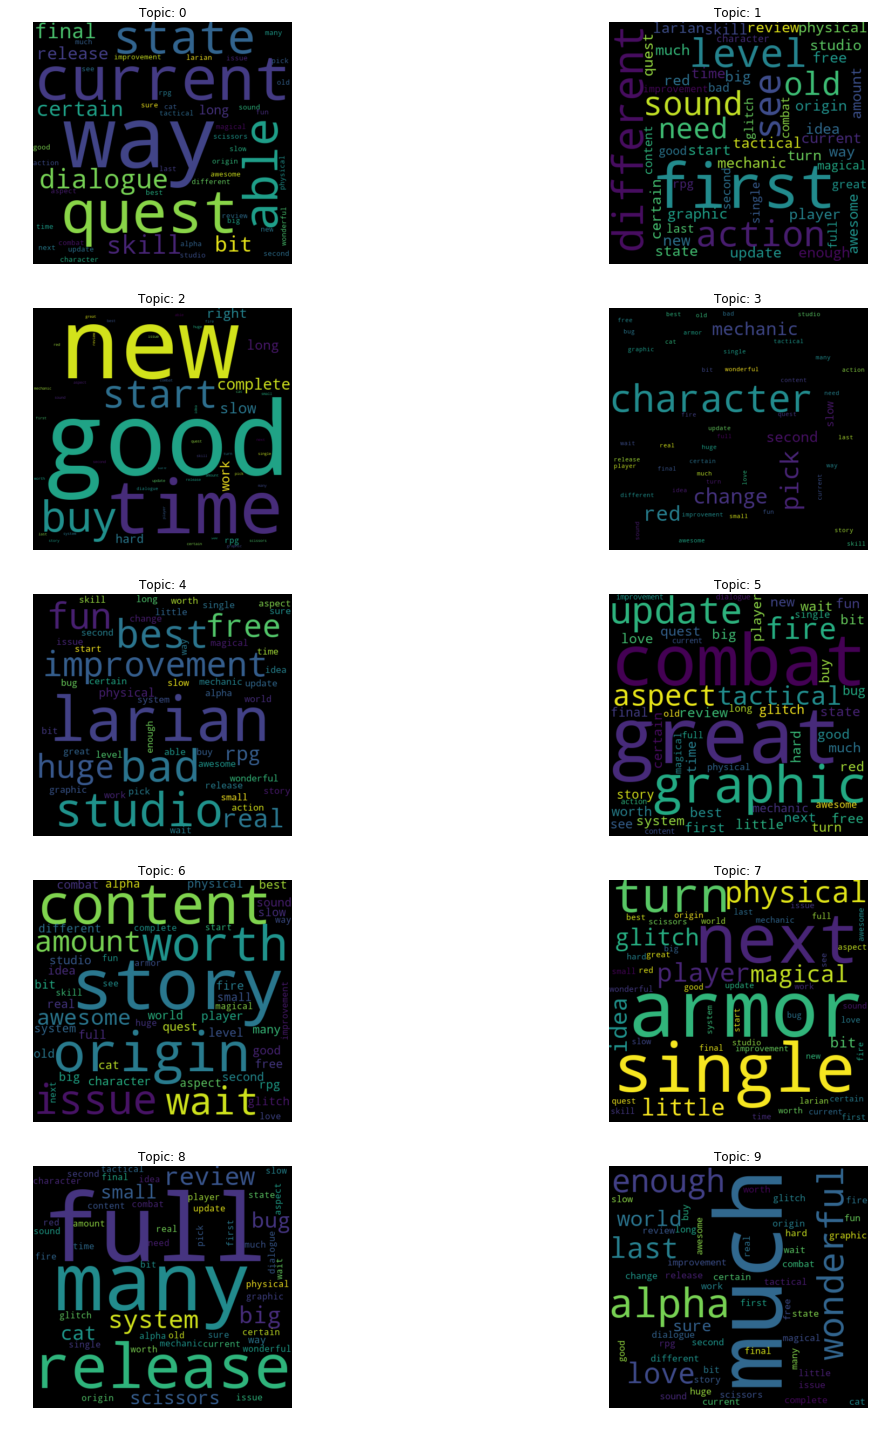

laptop gt520m
('surprise', 'NN')
['act', 'alpha', 'amount', 'armor', 'best', 'cant', 'certain', 'character', 'chinese', 'classic']
(759, 46)
iteration: 1 of max_iter: 30, perplexity: 311.5555


K:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


iteration: 2 of max_iter: 30, perplexity: 164.0282
iteration: 3 of max_iter: 30, perplexity: 119.5176
iteration: 4 of max_iter: 30, perplexity: 102.0518
iteration: 5 of max_iter: 30, perplexity: 94.2830
iteration: 6 of max_iter: 30, perplexity: 90.5444
iteration: 7 of max_iter: 30, perplexity: 88.6396
iteration: 8 of max_iter: 30, perplexity: 87.6191
iteration: 9 of max_iter: 30, perplexity: 87.0446
iteration: 10 of max_iter: 30, perplexity: 86.7047
iteration: 11 of max_iter: 30, perplexity: 86.4931
iteration: 12 of max_iter: 30, perplexity: 86.3542
iteration: 13 of max_iter: 30, perplexity: 86.2582


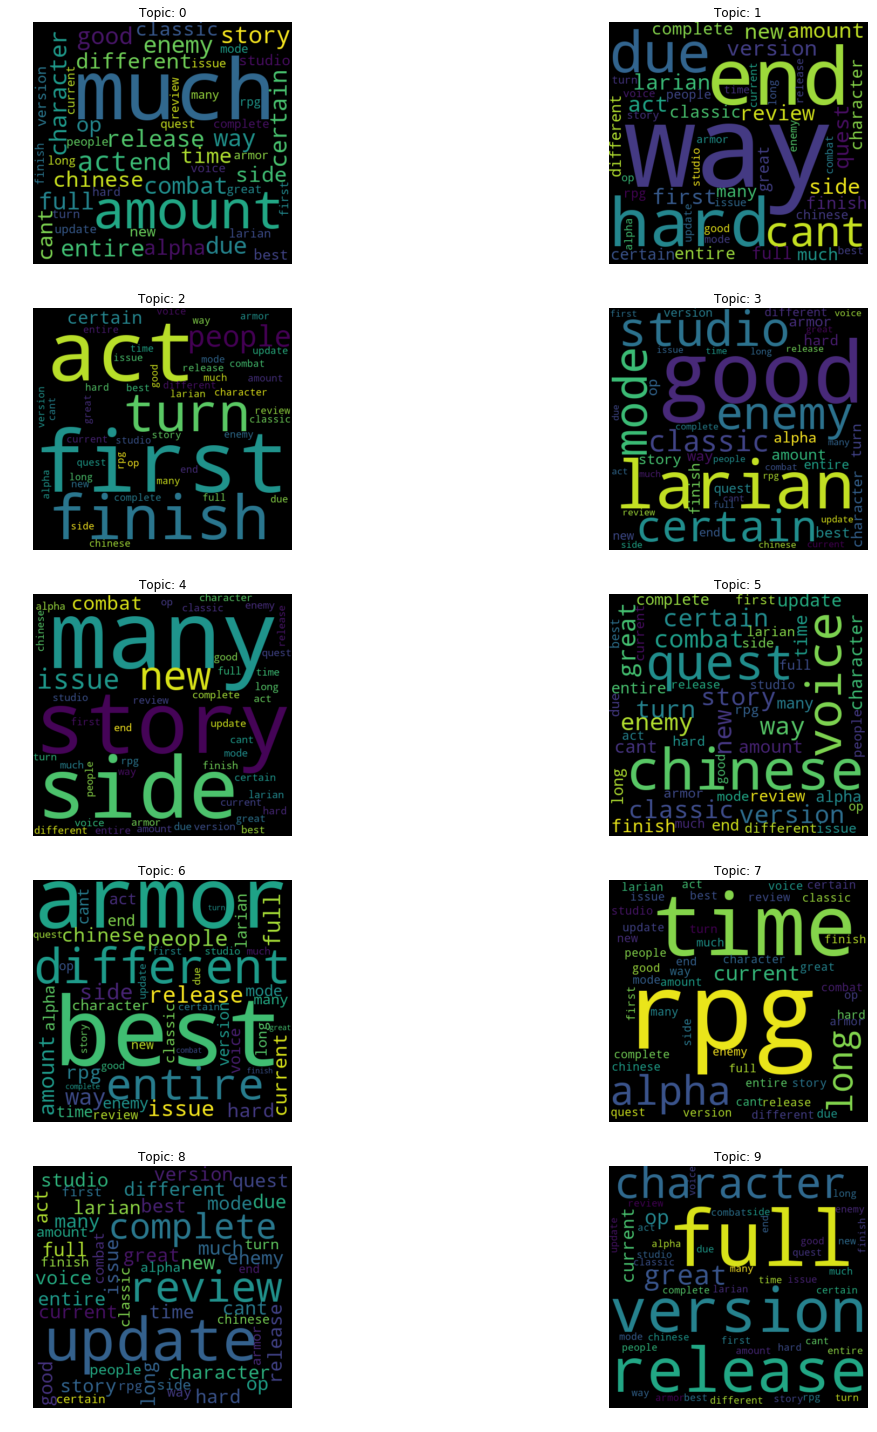

fantastical world
('gorgeous', 'JJ')
['alpha', 'area', 'armor', 'battle', 'best', 'bug', 'character', 'co', 'combat', 'complete']
(864, 60)
iteration: 1 of max_iter: 30, perplexity: 459.5762


K:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


iteration: 2 of max_iter: 30, perplexity: 228.7281
iteration: 3 of max_iter: 30, perplexity: 164.0597
iteration: 4 of max_iter: 30, perplexity: 139.2190
iteration: 5 of max_iter: 30, perplexity: 127.9015
iteration: 6 of max_iter: 30, perplexity: 122.4871
iteration: 7 of max_iter: 30, perplexity: 119.7495
iteration: 8 of max_iter: 30, perplexity: 118.2989
iteration: 9 of max_iter: 30, perplexity: 117.4981
iteration: 10 of max_iter: 30, perplexity: 117.0397
iteration: 11 of max_iter: 30, perplexity: 116.7683
iteration: 12 of max_iter: 30, perplexity: 116.6026
iteration: 13 of max_iter: 30, perplexity: 116.4982
iteration: 14 of max_iter: 30, perplexity: 116.4304


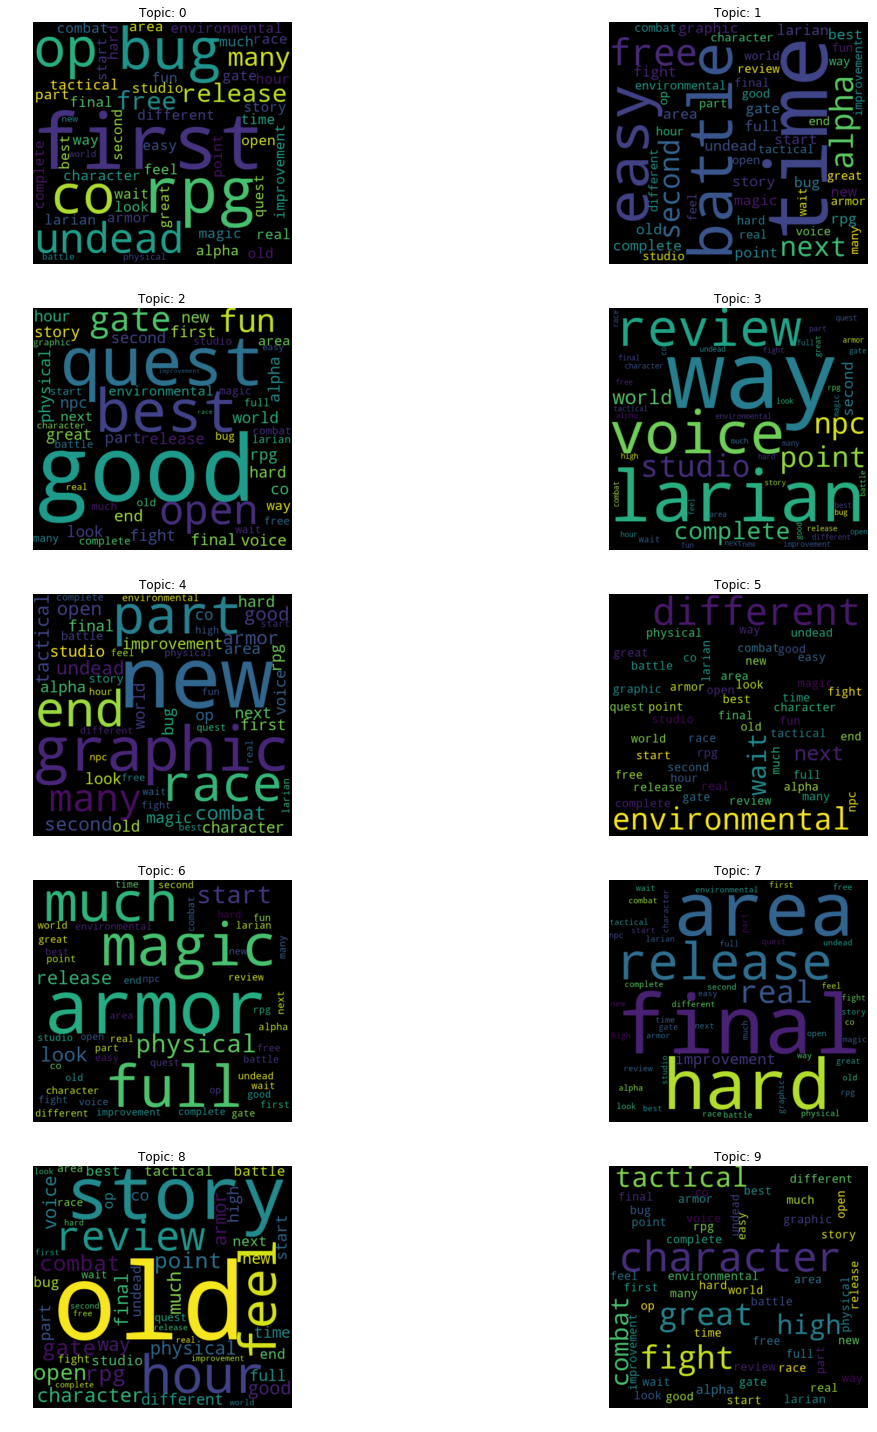

但是这次是发自内心的求中文 thanks
('这次不是评测', 'JJ')
['able', 'act', 'character', 'complete', 'coop', 'damage', 'different', 'enemy', 'first', 'full']
(500, 21)
iteration: 1 of max_iter: 30, perplexity: 374.9889
iteration: 2 of max_iter: 30, perplexity: 177.5428


K:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


iteration: 3 of max_iter: 30, perplexity: 113.4616
iteration: 4 of max_iter: 30, perplexity: 85.0233
iteration: 5 of max_iter: 30, perplexity: 70.3507
iteration: 6 of max_iter: 30, perplexity: 62.1127
iteration: 7 of max_iter: 30, perplexity: 57.2395
iteration: 8 of max_iter: 30, perplexity: 54.2552
iteration: 9 of max_iter: 30, perplexity: 52.3820
iteration: 10 of max_iter: 30, perplexity: 51.1837
iteration: 11 of max_iter: 30, perplexity: 50.4051
iteration: 12 of max_iter: 30, perplexity: 49.8922
iteration: 13 of max_iter: 30, perplexity: 49.5500
iteration: 14 of max_iter: 30, perplexity: 49.3189
iteration: 15 of max_iter: 30, perplexity: 49.1610
iteration: 16 of max_iter: 30, perplexity: 49.0518
iteration: 17 of max_iter: 30, perplexity: 48.9756


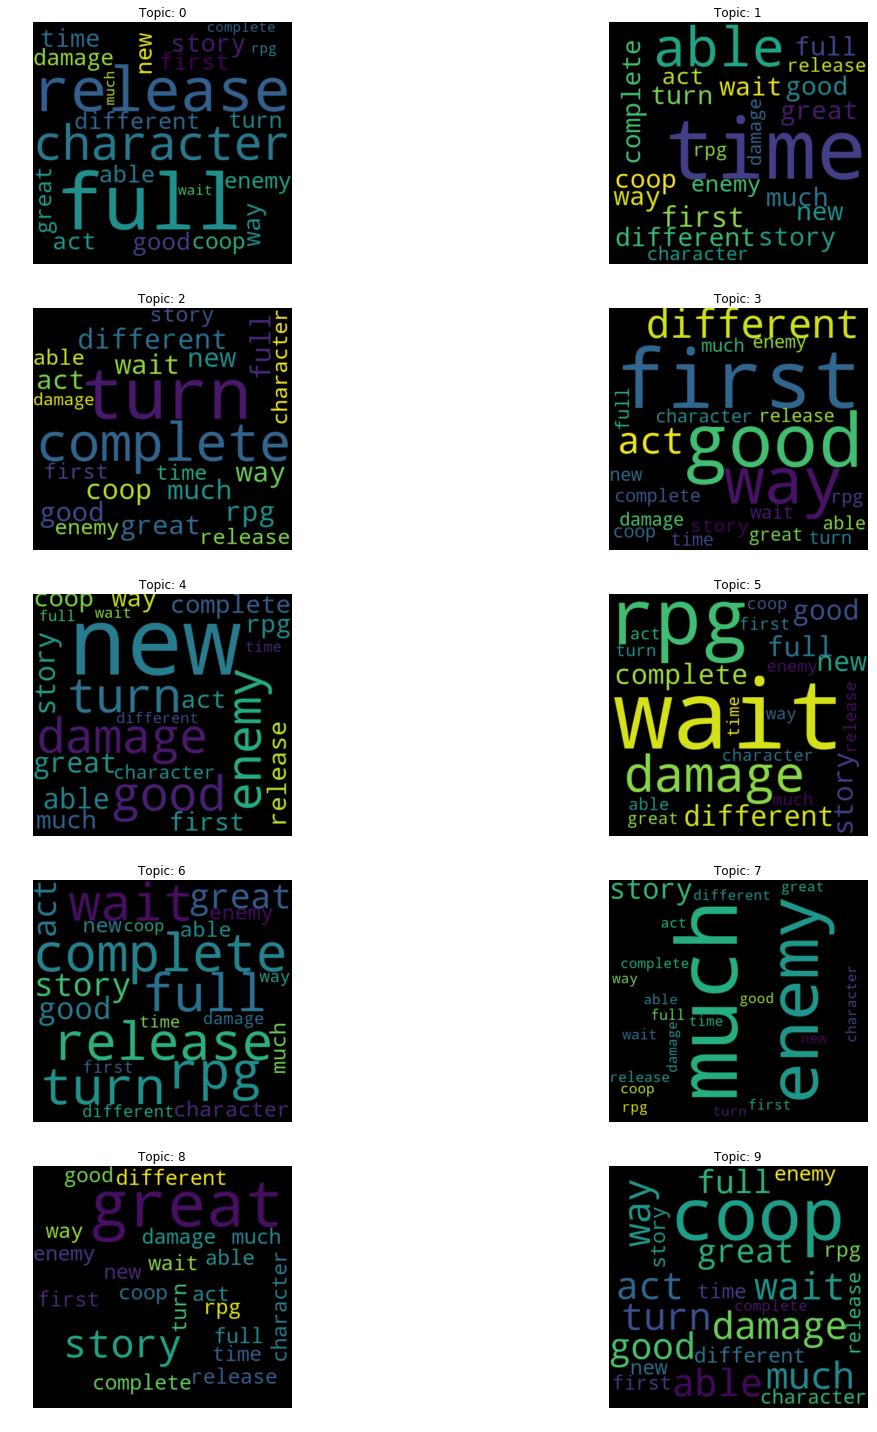

In [20]:
file_path1 = 'Patch_1.csv'
file_path2 = 'Patch_2.csv'
file_path3 = 'Patch_3.csv'
file_path4 = 'Patch_4.csv'
topic(file_path1)
topic(file_path2)
topic(file_path3)
topic(file_path4)

In [23]:
lda()

Topic 0:
[('plenty side', 132.2828678816968), ('tough opponent', 126.8267275047956), ('reviewer participate', 106.00169572716203), ('advanced beta', 100.95591763788345), ('much magic', 97.46107958322085), ('certain enemy', 69.97405748608949), ('dull i', 66.12593878881988), ('certain ability', 59.22440362815999), ('special get', 58.044298751392), ('kill thing', 56.57469414989552), ('great attack', 51.723872230660255), ('initial introduction', 47.47876079402863), ('replenish turn', 46.367363769384134), ('particular skill', 45.87946633103762), ('first act', 45.708073974109645), ('good someday', 45.619546508073206), ('enough make', 45.02096915497249), ('environmental status', 41.69890757781668), ('classic mode', 41.34467258397585), ('multiple enemy', 41.020385102991106)]


Topic 1:
[('html note', 239.26711195393622), ('simple idea', 181.47224415462736), ('bad trailer', 136.42634777700994), ('allow farm', 131.8975289825392), ('decent nothing', 117.3196675230409), ('euros thing', 109.4364742

## Classifiers

In [27]:
path1 = "BIA-660 Project Data Subset.csv"         # you need to change path here #
path2 = "positive-words.txt"                      # you need to change path here #
path3 = "negative-words.txt"                      # you need to change path here #
data,positive_words,negative_words=readfiles(path1,path2,path3)
run5models(data,positive_words,negative_words)


Average testing performance of Naive Bayes benchmarking model:
precision_macro: 0.8933685132197031
recall_macro: 0.505149043740077
f1_macro: 0.46288797337694537
accuracy: 0.826902320561252

Average testing performance of SVM benchmarking model:
precision_macro: 0.8583517286454294
recall_macro: 0.7724811320904322
f1_macro: 0.8055278591517678
accuracy: 0.9007771181867241

Average testing performance of Decision Tree benchmarking model:
precision_macro: 0.7203780848843515
recall_macro: 0.7038740546529558
f1_macro: 0.7112504895980125
accuracy: 0.8395824338909875

Average testing performance of KNN benchmarking model:
precision_macro: 0.8574484092410332
recall_macro: 0.5857507790737317
f1_macro: 0.6048888041971707
accuracy: 0.8511612924986508

Average testing performance of Neural Network benchmarking model:
precision_macro: 0.8295267628092514
recall_macro: 0.7736888128421828
f1_macro: 0.7970694058476331
accuracy: 0.8925114678899082


K:\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
K:\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)



Best parameters for Naive Bayes:
clf__alpha :  0.5
tfidf__min_df :  18
tfidf__stop_words :  english
best f1_macro: 0.7491830139746156

Average performance of modified NB model:
Precision_macro: 0.7812324390972155
Recall_macro: 0.7400032110466416
F1_macro: 0.7572523180368572
Accuracy: 0.8697281435509984

Best parameters for SVM:
clf__C :  1.5
tfidf__min_df :  2
tfidf__stop_words :  english
best f1_macro: 0.8115278803020823

Average performance of modified SVM model:
Precision_macro: 0.8416979284131726
Recall_macro: 0.7827208626600467
F1_macro: 0.8067585913132342
Accuracy: 0.8978383027522936
